<a href="https://colab.research.google.com/github/Jahan08/RDKit-application/blob/main/Chemical_space_analysis_and_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chemical space analysis of small molecule drugs with RDKit and dimensionality reduction methods
This is a quick tutorial on chemical space analysis and visualization with RDKit and dimensionality reduction methods PCA and t-SNE (sklearn). Due to the high dimensionality of chemical fingerprints, we have to use dimensionality reduction methods in order to facilitate the plotting of chemical space. Two popular methods are:
  - [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) - Principal component analysis
  - [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) - t-Distributed Stochastic Neighbor Embedding

We will use known drugs and try to see if there are differences between different classes of drugs in the projected chemical space.

@TAGS: #advanced #sklearn #PCA #t-SNE

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 48.4 MB/s eta 0:00:00


In [2]:
from __future__ import print_function
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

Load the table of drugs (downloaded from [ChEMBL](https://www.ebi.ac.uk/chembl/) )

In [4]:
df = pd.read_csv('/content/chembl_drugs.txt.gz', sep='\t')

In [5]:
len(df)

11442

Keep only compounds with SMILES, [USAN stems](https://www.ama-assn.org/about-us/united-states-adopted-names-approved-stems), that respect [Ro5](https://en.wikipedia.org/wiki/Lipinski's_rule_of_five) and are on the market

In [6]:
df = df[df['CANONICAL_SMILES'].notnull() & # Keep cpds with SMILES
        df['USAN_STEM'].notnull() & # USAN stem
        (df['RULE_OF_FIVE'] == 'Y') & # that respect Ro5
        (df['DEVELOPMENT_PHASE'] == 4)] # are on the market

In [7]:
len(df)

700

Add molecule column

In [8]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='CANONICAL_SMILES')

In [9]:
df = df[~df['ROMol'].isnull()]

In [10]:
len(df)

700

Check most common compound classees (based on USAN stem)

In [11]:
common_stems = df.groupby('USAN_STEM').size().sort_values()[-10:]
common_stems

USAN_STEM
-pin(e)    12
-tinib     12
-olone     12
-ium       14
-vir       15
-caine     15
-cillin    17
-oxacin    17
sulfa-     18
-olol      18
dtype: int64

In [12]:
stems = df.drop_duplicates(['USAN_STEM'])[df.drop_duplicates(['USAN_STEM'])['USAN_STEM'].isin(common_stems.index)][['USAN_STEM','USAN_STEM_DEFINITION']]
stems.index = stems['USAN_STEM']
stems['count'] = common_stems

In [13]:
stems

,USAN_STEM,USAN_STEM_DEFINITION,count
USAN_STEM,,,
-olone,-olone,steroids (not prednisolone derivatives),12
-oxacin,-oxacin,antibacterials (quinolone derivatives),17
-pin(e),-pin(e),tricyclic compounds,12
-tinib,-tinib,tyrosine kinase inhibitors,12
-caine,-caine,local anesthetics,15
sulfa-,sulfa-,antimicrobials (sulfonamides derivatives),18
-vir,-vir,antivirals: antivirals (acyclovir type),15
-ium,-ium,quaternary ammonium derivatives,14
-cillin,-cillin,penicillins,17


Helper functions

In [14]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

class FP:
    """
    Molecular fingerprint class, useful to pack features in pandas df

    Parameters
    ----------
    fp : np.array
        Features stored in numpy array
    names : list, np.array
        Names of the features
    """
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

def get_cfps(mol, radius=2, nBits=1024, useFeatures=False, counts=False, dtype=np.float32):
    """Calculates circular (Morgan) fingerprint.
    http://rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints

    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
    radius : float
        Fingerprint radius, default 2
    nBits : int
        Length of hashed fingerprint (without descriptors), default 1024
    useFeatures : bool
        To get feature fingerprints (FCFP) instead of normal ones (ECFP), defaults to False
    counts : bool
        If set to true it returns for each bit number of appearances of each substructure (counts). Defaults to false (fingerprint is binary)
    dtype : np.dtype
        Numpy data type for the array. Defaults to np.float32 because it is the default dtype for scikit-learn

    Returns
    -------
    ML.FP
        Fingerprint (feature) object
    """
    arr = np.zeros((1,), dtype)

    if counts is True:
        info = {}
        fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits, useFeatures=useFeatures)
        DataStructs.ConvertToNumpyArray(fp, arr)
    else:
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    return FP(arr, range(nBits))

Calculate fingerprints

In [15]:
df['FP'] = df['ROMol'].map(get_cfps)

Extract compounds that belong to 10 most common USAN stems

In [16]:
df_small = df[df['USAN_STEM'].isin(list(stems.index))].copy()

In [17]:
len(df_small)

150

### PCA analysis

In [18]:
from sklearn.decomposition import PCA

In [19]:
X = np.array([x.fp for x in df_small['FP']])

In [20]:
pca = PCA(n_components=3, random_state=0)
pca_drugs = pca.fit_transform(X)

In [21]:
df_small['PC1'] = pca_drugs.T[0]
df_small['PC2'] = pca_drugs.T[1]
df_small['PC3'] = pca_drugs.T[2]

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

Plot principal components

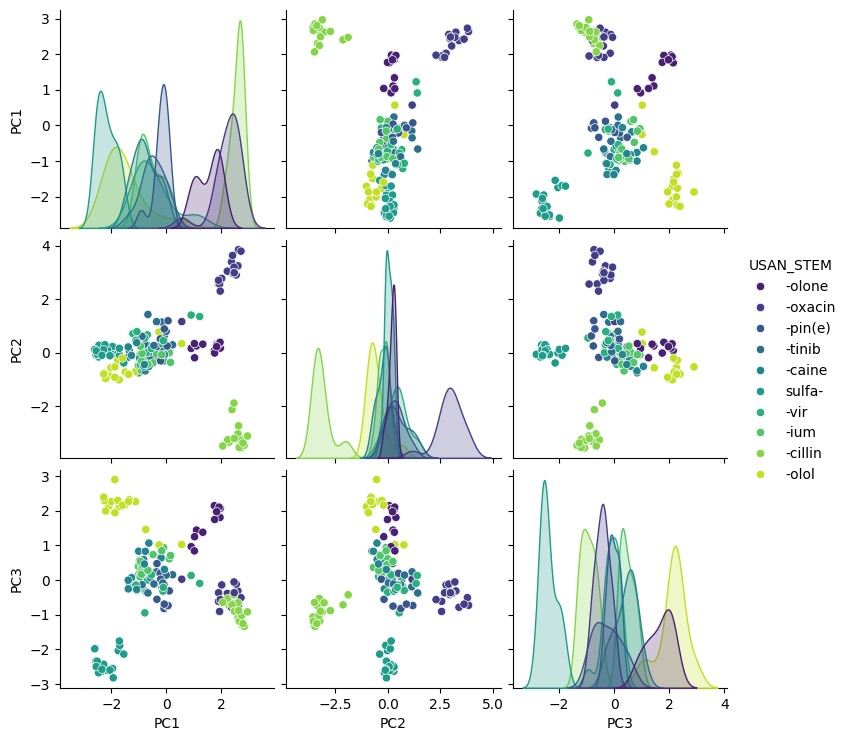

In [23]:
#doctest: IGNORE
sns.pairplot(df_small, hue='USAN_STEM', vars=['PC1', 'PC2', 'PC3'], palette='viridis');

### t-SNE
Note that [t-SNE is very sensitive to hyperparameter settings](http://distill.pub/2016/misread-tsne/).
#### Without PCA preprocessing

In [24]:
from sklearn.manifold import TSNE

In [25]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_drugs = model.fit_transform(X)

In [26]:
df_small['TSNE_C1'] = tsne_drugs.T[0]
df_small['TSNE_C2'] = tsne_drugs.T[1]

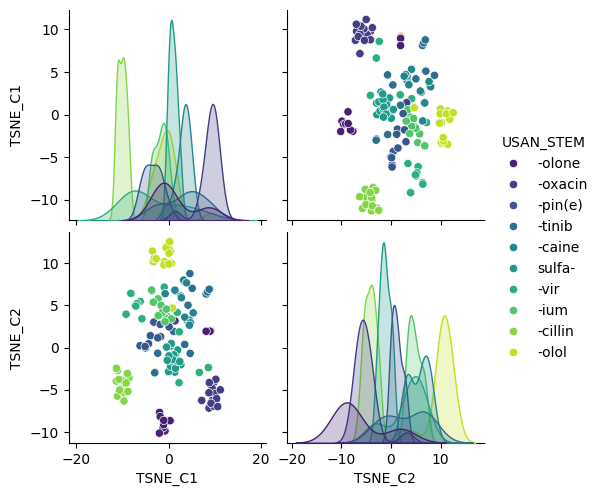

In [27]:
#doctest: IGNORE
sns.pairplot(df_small, hue='USAN_STEM', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis');

#### With PCA preprocessing
In case of high dimensionality data (like molecular fingerprints) it is recommended to reduce the number of dimensions with another method before proceeding with t-SNE.

In [28]:
pca_model = PCA(n_components=30, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_pca_drugs = tsne_model.fit_transform(pca_model.fit_transform(X))

In [29]:
df_small['TSNE_PCA_C1'] = tsne_pca_drugs.T[0]
df_small['TSNE_PCA_C2'] = tsne_pca_drugs.T[1]

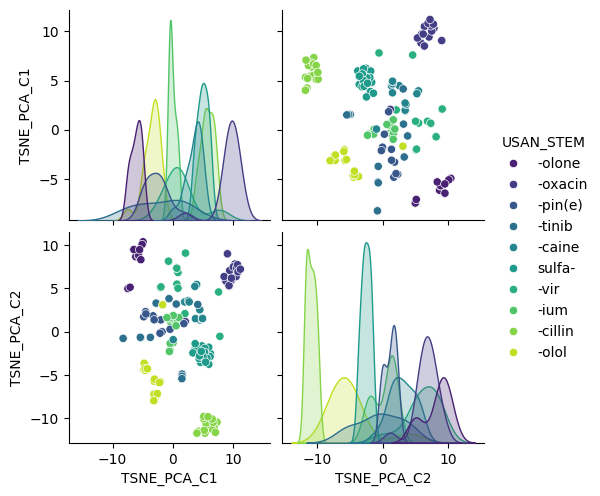

In [30]:
#doctest: IGNORE
sns.pairplot(df_small, hue='USAN_STEM', vars=['TSNE_PCA_C1', 'TSNE_PCA_C2'], palette='viridis');

Tutorial author: Samo Turk, Jan. 2017